## Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

## Описание колонок
* `experimentVariant` – вариант эксперимента
* `version` – версия приложения
* `purchase` – факт покупки

## Задача
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

### 💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

* Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
* Посчитайте pvalue для каждой версии МП
* Найдите версии, где pvalue < 0.05
* Исключите версию с pvalue < 0.05 из основного датафрейма
* Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
* Вы нашли поломку

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

plt.style.use('ggplot')

In [4]:
df = pd.read_csv('data2/hw_aa.csv', sep=';')
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Поделим данные на две группы.

In [5]:
df = df.rename(columns={'experimentVariant': 'exp'})
df.head()
df0 = df.query('exp==0')
df1 = df.query('exp==1')

In [44]:
def AA(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    boot_len = 1000,
    boot_len_persists = False,
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    if boot_len_persists == True:
        boot_len = round(min(len(data_column_1), len(data_column_2)))
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        s1 = data_column_1.sample(
            boot_len, 
            replace = False # параметр возвращения
        ).values
        
        s2 = data_column_2.sample(
            boot_len, 
            replace = False
        ).values
        
        boot_data.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 
                
    # Визуализация
    plt.hist(boot_data, bins = 50)
    
    plt.style.use('ggplot')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    print('FPR =', sum(np.array(boot_data) < 0.05) / boot_it) 

### Запускаем А/А тест

  0%|          | 0/1000 [00:00<?, ?it/s]

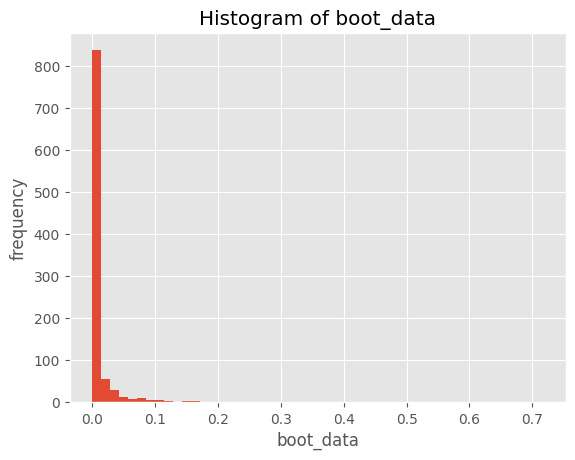

FPR = 0.934


In [126]:
AA(df0.purchase,
    df1.purchase)

(widget результат которого не сохранился, это tdqm - прогресс теста)

### Результат A/A-теста
`FPR > 0.05`, т.е. доля ложноположительных оценок (доля симуляций, в которых был получен `p < 0.05`) составляет больше `5%`, причем значительно больше. Таким образом, в подавляющем большинстве случаев мы получаем статистически значимые различия между двумя группами, которых на самом деле быть не должно. Значит, что-то пошло не так, и необходимо искать причину поломки.

## Начинаем искать поломку
Сгруппируем наш датасет по номеру группы и посчитаем конверсию.

In [12]:
df.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [109]:
df_conv = df0.groupby('version').agg(
    conv0=('purchase', lambda x: sum(x)/x.count()))
df_conv['conv1'] = df1.groupby('version').agg(
    conv1=('purchase', lambda x: sum(x)/x.count())).conv1
df_conv
#2.8.0 как то не оч себя ведет

,conv0,conv1
version,,
v2.8.0,0.000993,0.045606
v2.9.0,0.074658,0.071304
v3.7.4.0,0.059943,0.063018
v3.8.0.0,0.057604,0.062848


Можно заметить, что конверсия для версии `v2.8.0` заметно различается в двух вариантах эксперимента (в нулевую группу попадает значительно меньше покупателей, чем в первую). В результате нарушается репрезентативность тестовых групп. Возможно, причина поломки именно в этой версии приложения.

## Попробуем запустить A/A-тест для каждой версии приложения по отдельности

  0%|          | 0/1000 [00:00<?, ?it/s]

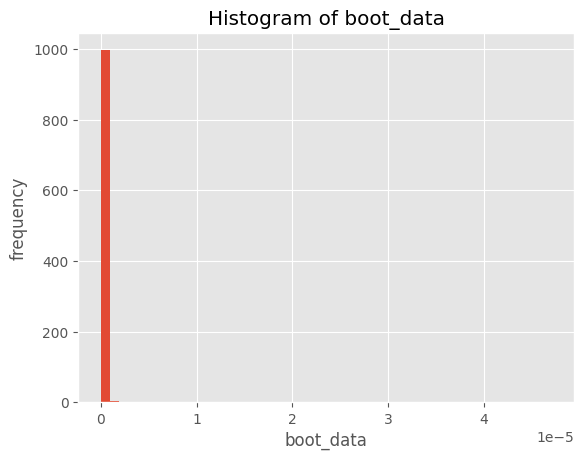

FPR = 1.0
is for v2.8.0


  0%|          | 0/1000 [00:00<?, ?it/s]

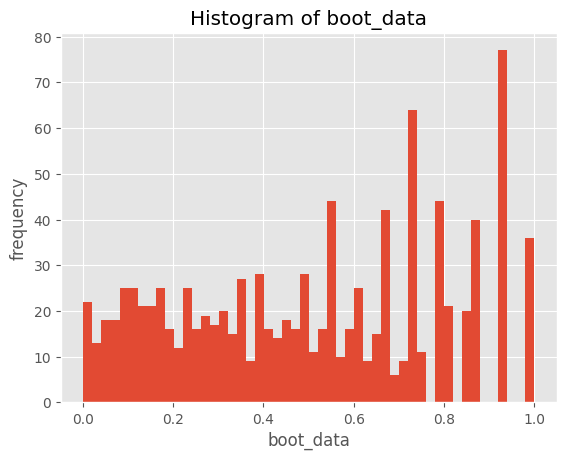

FPR = 0.044
is for v2.9.0


  0%|          | 0/1000 [00:00<?, ?it/s]

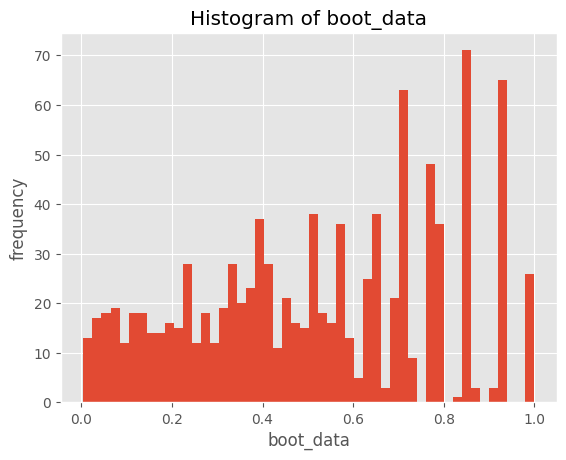

FPR = 0.034
is for v3.7.4.0


  0%|          | 0/1000 [00:00<?, ?it/s]

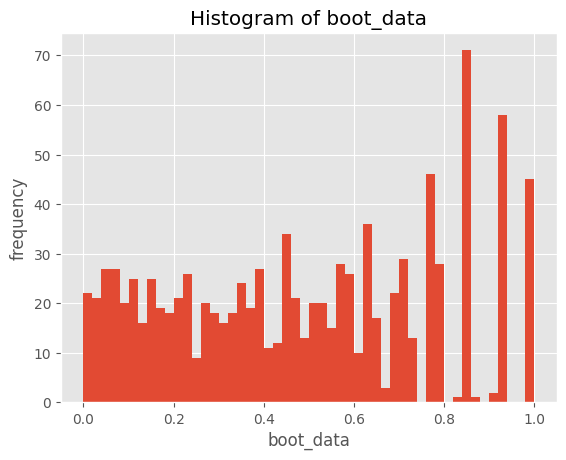

FPR = 0.055
is for v3.8.0.0


In [131]:
pval = []
for x in df['version'].unique():
    y = AA(df0.query('version==@x').purchase,
    df1.query('version==@x').purchase)
    print('is for', x)

PS небольшое превышение 0.05 объясняется маленьким размером выборок (1000)

<br>Посчитаем с сэмплированием длины меньшей из выборок - значения FPR станут меньше

  0%|          | 0/1000 [00:00<?, ?it/s]

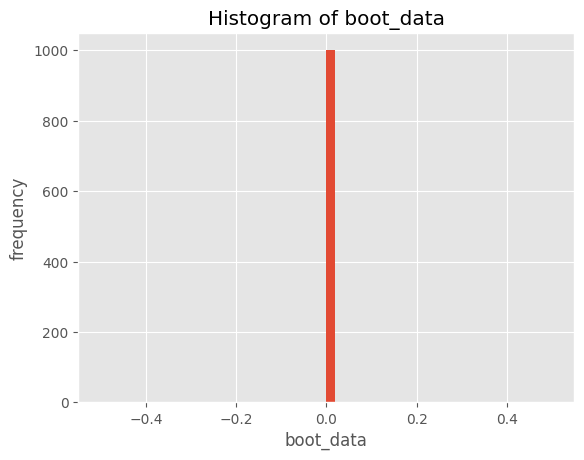

FPR = 1.0
is for v2.8.0


  0%|          | 0/1000 [00:00<?, ?it/s]

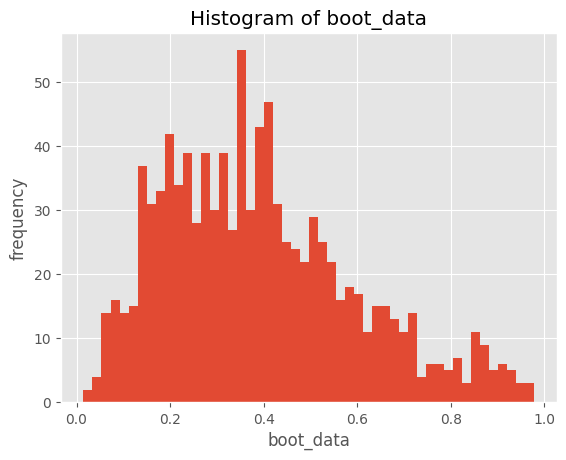

FPR = 0.005
is for v2.9.0


  0%|          | 0/1000 [00:00<?, ?it/s]

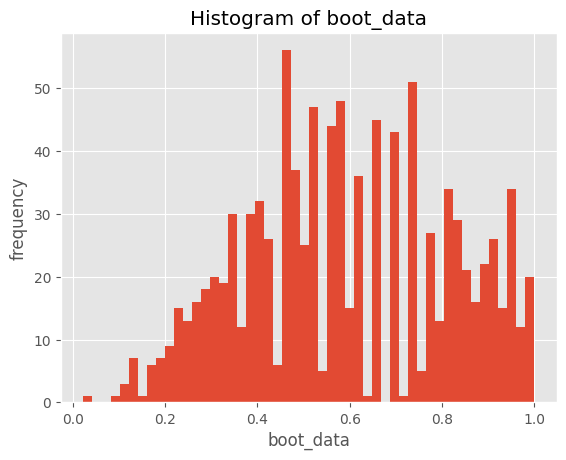

FPR = 0.001
is for v3.7.4.0


  0%|          | 0/1000 [00:00<?, ?it/s]

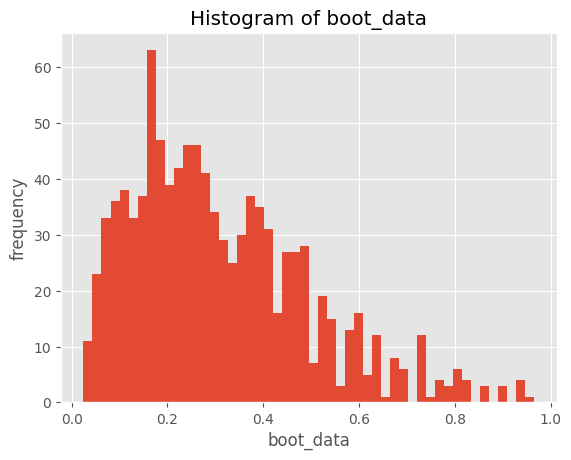

FPR = 0.016
is for v3.8.0.0


In [46]:
for x in df['version'].unique():
    y = AA(df0.query('version==@x').purchase,
    df1.query('version==@x').purchase,
    boot_len_persists=True) 
    print('is for', x)

### Результаты A/A-теста для каждой версии приложения
Теперь хорошо видно, что для версии `v2.8.0` t-тест выдает значимые различия на каждой итерации теста (`FPR составляет 1.0`), тогда как с остальными версиями все нормально - доля ложноположительных оценок низкая. Значит, причина поломки действительно кроется в версии `v2.8.0`. Возможно, что для данной версии сломан рандомизатор, распределяющий пользователей по группам эксперимента.

## Теперь запустим A/A-тест, предварительно исключив из выборки проблемную версию

In [133]:
df0b = df0.query('version!="v2.8.0"')
df1b = df0.query('version!="v2.8.0"')

  0%|          | 0/1000 [00:00<?, ?it/s]

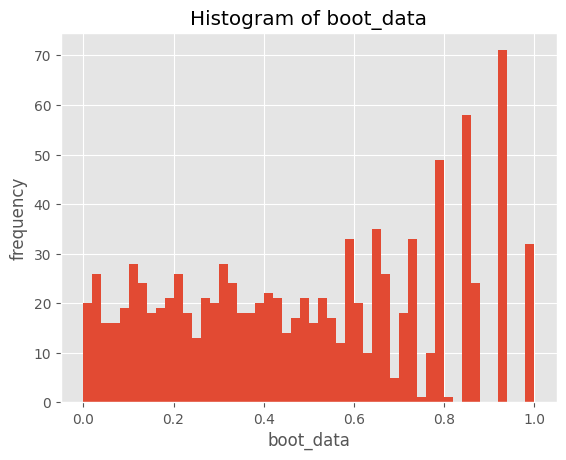

FPR = 0.054


In [136]:
AA(df0b.purchase,
    df1b.purchase)

Без проблемной версии `все работает нормально`, и мы находимся в пределах допустимого значения `FPR`. Теперь мы знаем, что именно у нас сломалось. Ура!

P.S. Также можно заметить, что в нашем примере при повторных запусках А/А-тестов в некоторых случаях FPR будет немного превышать пороговое значение (`0.05`). Это связано с относительно небольшим числом наблюдений (`1000`) в выборках на каждой итерации теста. Если увеличить это значение (например, до 90% от числа наблюдений в исходных группах), то оценка `FPR` будет более точной.